# BDP kaggle notebook

## Imports & Configurations

In [1]:
!pip install kaggle --upgrade
!pip install missingno
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark

--2023-01-24 07:29:53--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299350810 (285M) [application/x-gzip]
Saving to: ‘./spark-3.3.1-bin-hadoop3.tgz’

./spark-3.3.1-bin-h 100%[===================>] 285.48M   196MB/s    in 1.5s    

2023-01-24 07:29:55 (196 MB/s) - ‘./spark-3.3.1-bin-hadoop3.tgz’ saved [299350810/299350810]

spark-3.3.1-bin-hadoop3/
spark-3.3.1-bin-hadoop3/LICENSE
spark-3.3.1-bin-hadoop3/NOTICE
spark-3.3.1-bin-hadoop3/R/
spark-3.3.1-bin-hadoop3/R/lib/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3

In [3]:
import findspark
import random
import pyspark
from pyspark.sql import functions as f
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler, OneHotEncoder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from sklearn.metrics import jaccard_score
import itertools
import re
from matplotlib import pyplot as plt
import seaborn as sns 
from functools import reduce
import scipy.spatial
import missingno as msno


import warnings
warnings.filterwarnings('ignore')

In [4]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/kaggle/working/spark-3.3.1-bin-hadoop3"
findspark.init()

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/big-data-platforms-competition-2023/bdp_train.csv
/kaggle/input/big-data-platforms-competition-2023/sampleSubmission.csv
/kaggle/input/big-data-platforms-competition-2023/bdp_test.csv


In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('treatmeant').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/24 07:30:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### __Read the dataset__

In [7]:
# Use Spark to read the training csv file.
bdp_train = spark.read.csv("/kaggle/input/big-data-platforms-competition-2023/bdp_train.csv", inferSchema=True, header=True)
bdp_test = spark.read.csv("/kaggle/input/big-data-platforms-competition-2023/bdp_test.csv", inferSchema=True, header=True)

In [8]:
print(f'Train dataset shape: ({bdp_train.count()}, {len(bdp_train.columns)})')
print(f'Test dataset shape: ({bdp_test.count()}, {len(bdp_test.columns)})')

Train dataset shape: (7436, 454)
Test dataset shape: (3186, 453)


In [9]:
bdp_train_pd = bdp_train.to_pandas_on_spark()

In [10]:
bdp_train_pd.describe()

23/01/24 07:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1095.3 KiB


23/01/24 07:31:18 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/01/24 07:31:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,Index,A84,A85,A86,A87,A88,A89,A90,A91,A92,A93,A94,A95,A96,A97,A98,A99,A100,A101,A102,A103,A104,A105,A106,A107,A108,A109,A110,A111,A112,A113,A114,A115,A116,A117,A118,A119,A120,A121,A122,A123,A124,A125,A126,A127,A128,A129,A130,A131,A132,A133,A134,A135,A136,A137,A138,A139,A140,A141,A142,A143,A144,A145,A146,A147,A148,A149,A150,A151,A152,A153,A154,A155,A156,A157,A158,A159,A160,A161,A162,A163,A164,A165,A166,A167,A168,A169,A170,A171,A172,A173,A174,A175,A176,A177,A178,A179,A180,A181,A182,A183,A184,A185,A186,A187,A188,A189,A190,A191,A192,A193,A194,A195,A196,A197,A198,A199,A200,A201,A202,A203,A204,A205,A206,A207,A208,A209,A210,A211,A212,A213,A214,A215,A216,A217,A218,A219,A220,A221,A222,A223,A224,A225,A226,A227,A228,A229,A230,A231,A232,A233,A234,A235,A236,A237,A238,A239,A240,A241,A242,A271,A272,A273,A274,A275,A276,A277,A278,A279,A280,A281,A282,A283,A284,A285,A286,A287,A288,A289,A290,A291,A295,A296,A297,A298,A299,A300,A301,A302,A303,A304,A305,A306,A307,A308,A309,A310,A311,A312,A313,A314,A315,A316,A318,A319,A320,A321,A322,A323,A324,A325,A327,A328,A329,A330,A333,A358,A359,A360,A361,A362,A363,A364,A365,A366,A367,A368,A369,A370,A371,A372,A373,A374,A375,A376,A377,A378,A379,A380,A381,A382,A383,A384,A385,A386,A387,A388,A389,A390,A391,A392,A393,A394,A395,A396,A397,A398,A399,A400,A401,A402,A403,A404,A405,A406,A407,A408,A409,A410,A411,A412,A413,A414,A415,A416,A417,A418,A419,A420,A421,A422,A423,A424,A425,A426,A427,A428,A429,A430,A431,A432,A433,A434,A436,A437,A438,A439,A440,A441,A442,A443,A444,A445,A446,A447,A448,A449,A450,A451,A452
count,7436.000000,6101.000000,3011.000000,50.000000,7065.000000,4983.000000,3939.000000,6482.000000,3439.000000,4016.000000,1107.000000,863.000000,1225.000000,7393.000000,4010.000000,127.000000,265.000000,7436.000000,7436.000000,2859.000000,3669.000000,897.000000,664.000000,214.000000,56.000000,751.000000,308.000000,828.000000,1075.000000,6996.000000,7352.000000,10.000000,3556.000000,10.000000,3860.000000,3631.000000,1091.000000,3659.000000,3646.000000,1066.000000,1451.000000,1882.000000,694.000000,191.000000,2.538000e+03,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.00000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.0,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.0,7436.000000,38.0,376.0,44.0,13.0,6.0,26.0,16.0,2.0,8.0,33.0,656.0,65.0,84.0,13.0,61.0,34.0,4.0,9.0,53.0,10.0,13.0,20.0,29.0,15.0,15.0,12.0,7.0,14.0,14.0,5.0,8.0,8.0,8.0,1.0,1.0,7436.000000,365.0,174.0,83.0,1689.0,72.0,105.0,28.0,74.0,157.0,26.0,28.0,39.0,82.0,110.0,18.0,9.0,48.0,42.0,16.0,13.0,7436.000000,727.0,389.0,439.0,111.0,96.0,37.0,166.0,18.0,24.0,67.0,8.0,37.0,24.0,30.0,79.0,22.0,8.0,13.0,9.0,21.0,18.0,63.0,7.0,3.0,32.0,9.0,11.0,10.0,2.0,3.0,23.0,6.0,7.0,47.0,7436.000000,36.000000,1947.000000,253.000000,56.000000,66.000000,7436.000000,7436.0,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.0,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.0,7436.00000

In [11]:
pattern = re.compile("^A[1-9]$|^A[1-7][0-9]$|^A8[0-3]$")
string_columns = [column for column in bdp_train_pd.columns if pattern.match(column)]
bdp_train_pd.loc[:, string_columns].info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 7436 entries, 0 to 7435
Data columns (total 83 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   A1      7436 non-null   object
 1   A2      0 non-null      object
 2   A3      1 non-null      object
 3   A4      7436 non-null   object
 4   A5      2 non-null      object
 5   A6      2 non-null      object
 6   A7      39 non-null     object
 7   A8      15 non-null     object
 8   A9      10 non-null     object
 9   A10     7 non-null      object
 10  A11     1 non-null      object
 11  A12     1 non-null      object
 12  A13     7436 non-null   object
 13  A14     10 non-null     object
 14  A15     225 non-null    object
 15  A16     194 non-null    object
 16  A17     3254 non-null   object
 17  A18     36 non-null     object
 18  A19     16 non-null     object
 19  A20     7 non-null      object
 20  A21     6 non-null      object
 21  A22     36 non-null     object
 22  A23     22 non-null  

### __Filter columns with a single value__

In [12]:
expression = [f.countDistinct(c).alias(c) for c in bdp_train.columns]
num_distinct_values_df = bdp_train.select(*expression)

23/01/24 07:31:35 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/01/24 07:34:02 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


23/01/24 07:34:06 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


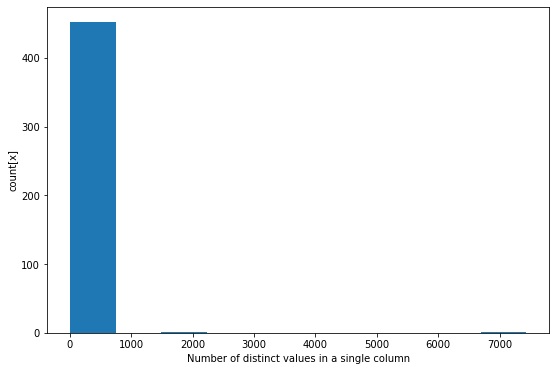

In [13]:
first_row_distinct_values = num_distinct_values_df.first()
num_distinct_values = np.array([first_row_distinct_values[c] for c in num_distinct_values_df.columns])

fig = plt.figure(figsize=(9, 6))
plt.hist(num_distinct_values)
plt.xlabel('Number of distinct values in a single column')
plt.ylabel('count[x]')
plt.show()

In [14]:
valid_columns =  [c for c in num_distinct_values_df.columns if first_row_distinct_values[c] > 1]

print(f'Number of columns with 2 or more classes (not including index, class): {len(valid_columns) - 2}')

Number of columns with 2 or more classes (not including index, class): 243


In [15]:
bdp_train_valid_columns = bdp_train.select(valid_columns)
bdp_test_valid_columns = bdp_test.select(valid_columns[:-1])

### __Filter columns with large number of nulls__

In [16]:
bdp_train_valid_columns_pd = bdp_train_valid_columns.to_pandas_on_spark()

<AxesSubplot:>

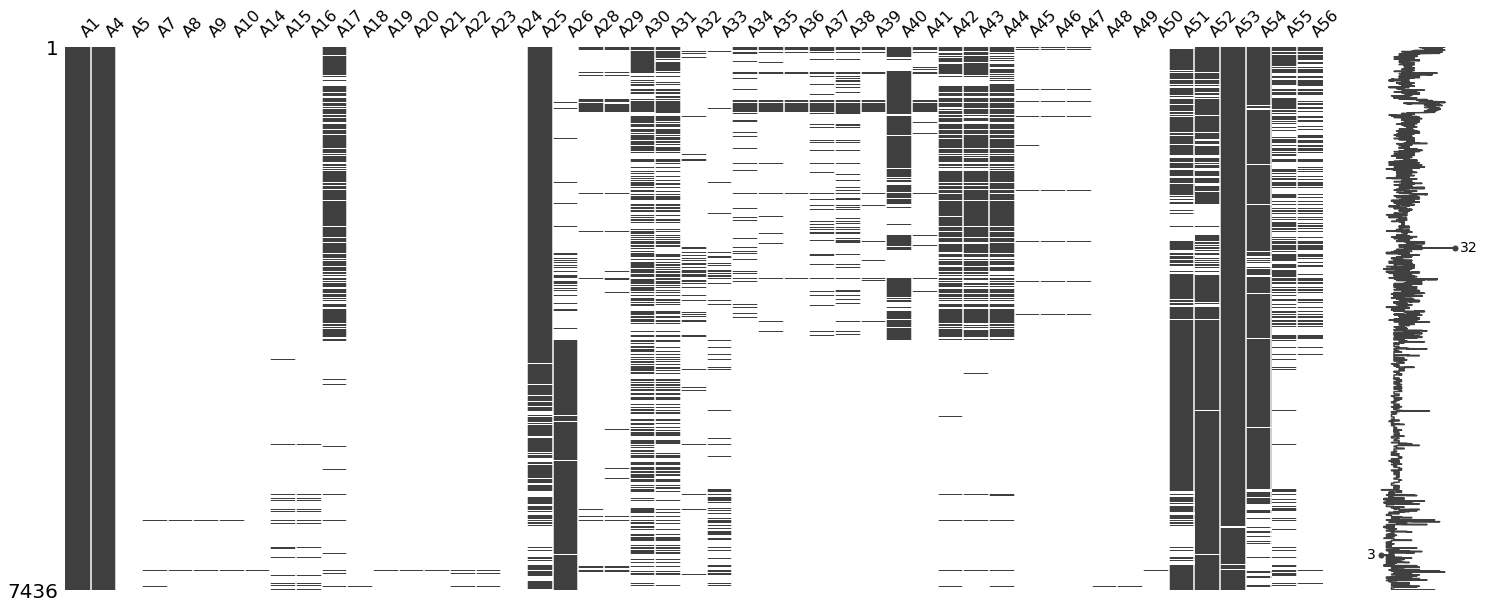

In [17]:
msno.matrix(bdp_train_valid_columns_pd.iloc[:, 1:50])

<AxesSubplot:>

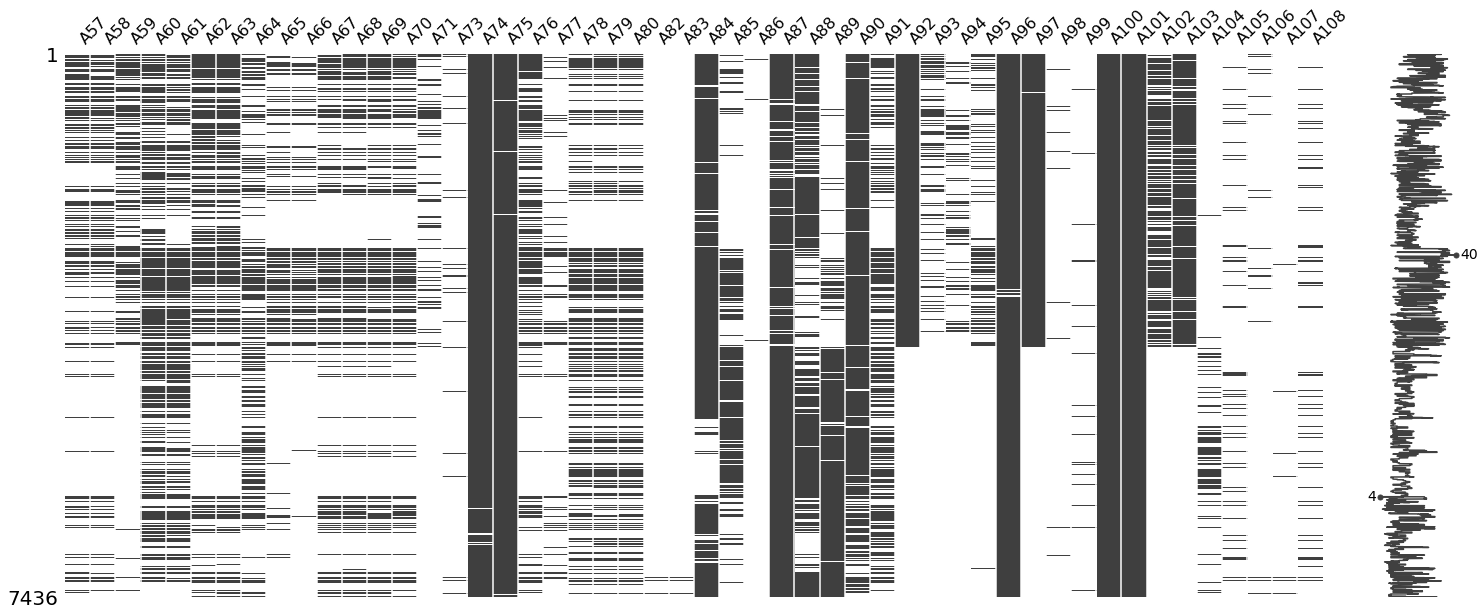

In [18]:
msno.matrix(bdp_train_valid_columns_pd.iloc[:, 50:100])

<AxesSubplot:>

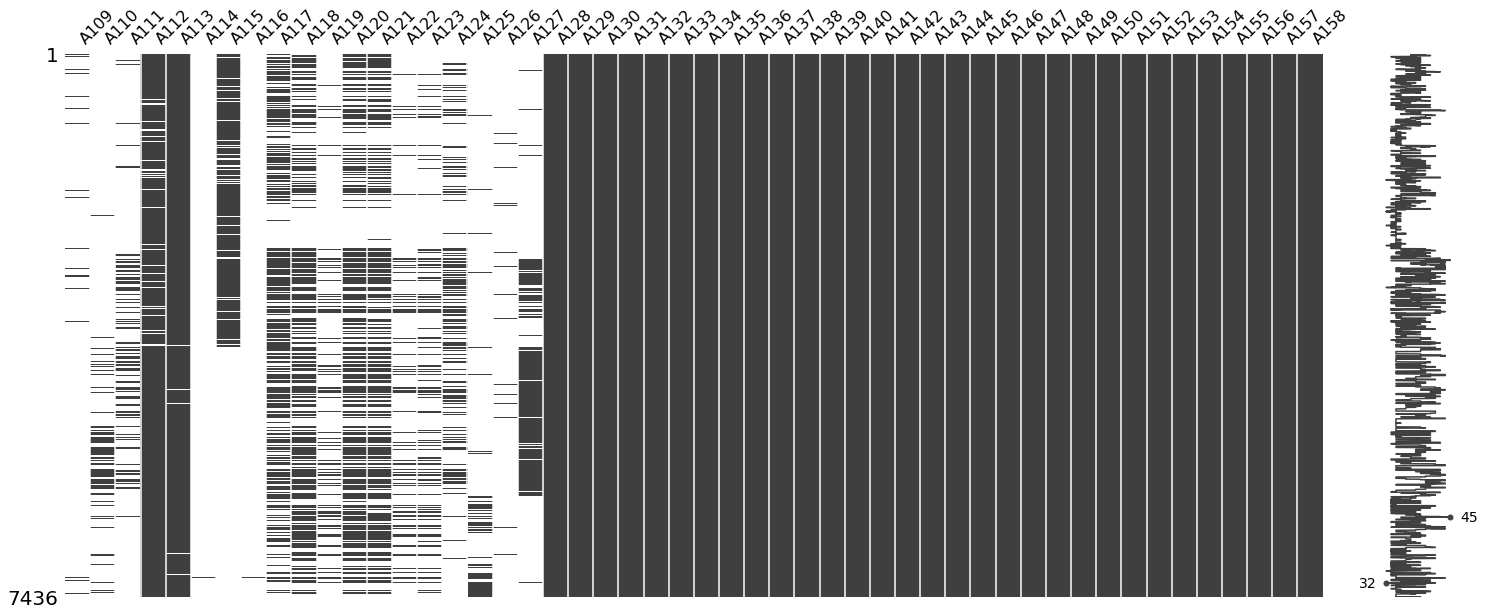

In [19]:
msno.matrix(bdp_train_valid_columns_pd.iloc[:, 100:150])

<AxesSubplot:>

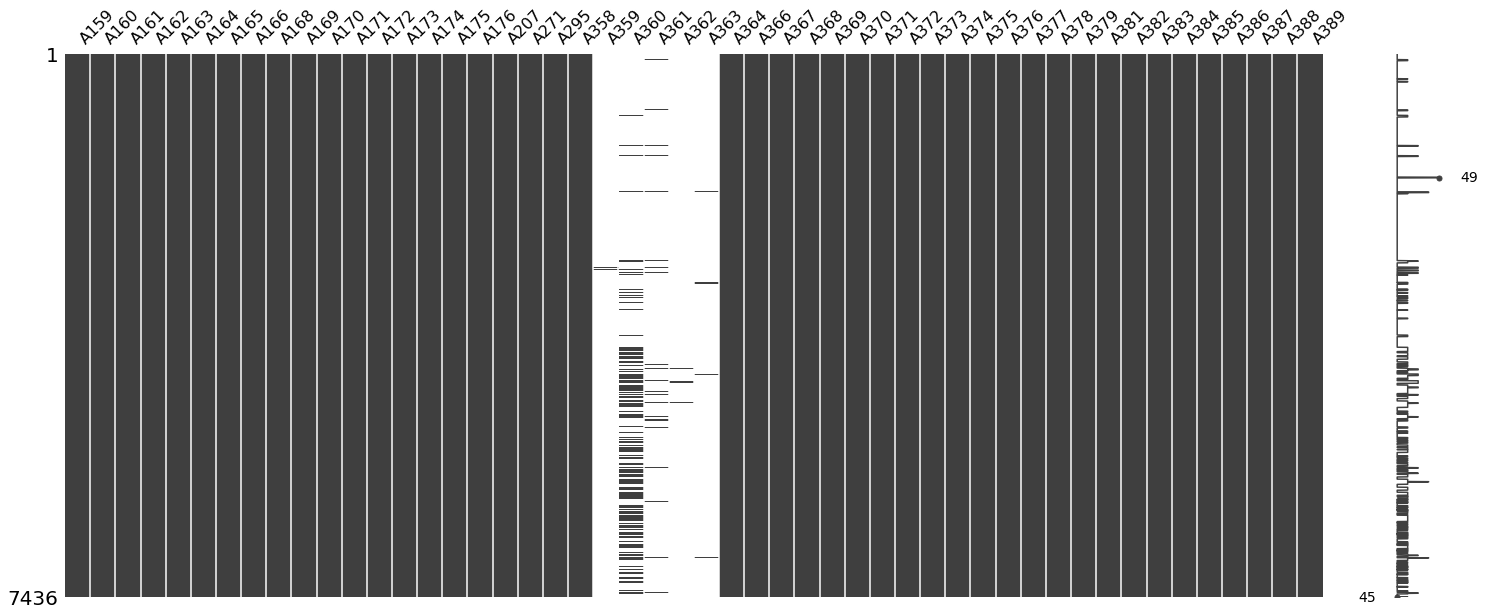

In [20]:
msno.matrix(bdp_train_valid_columns_pd.iloc[:, 150:200])

<AxesSubplot:>

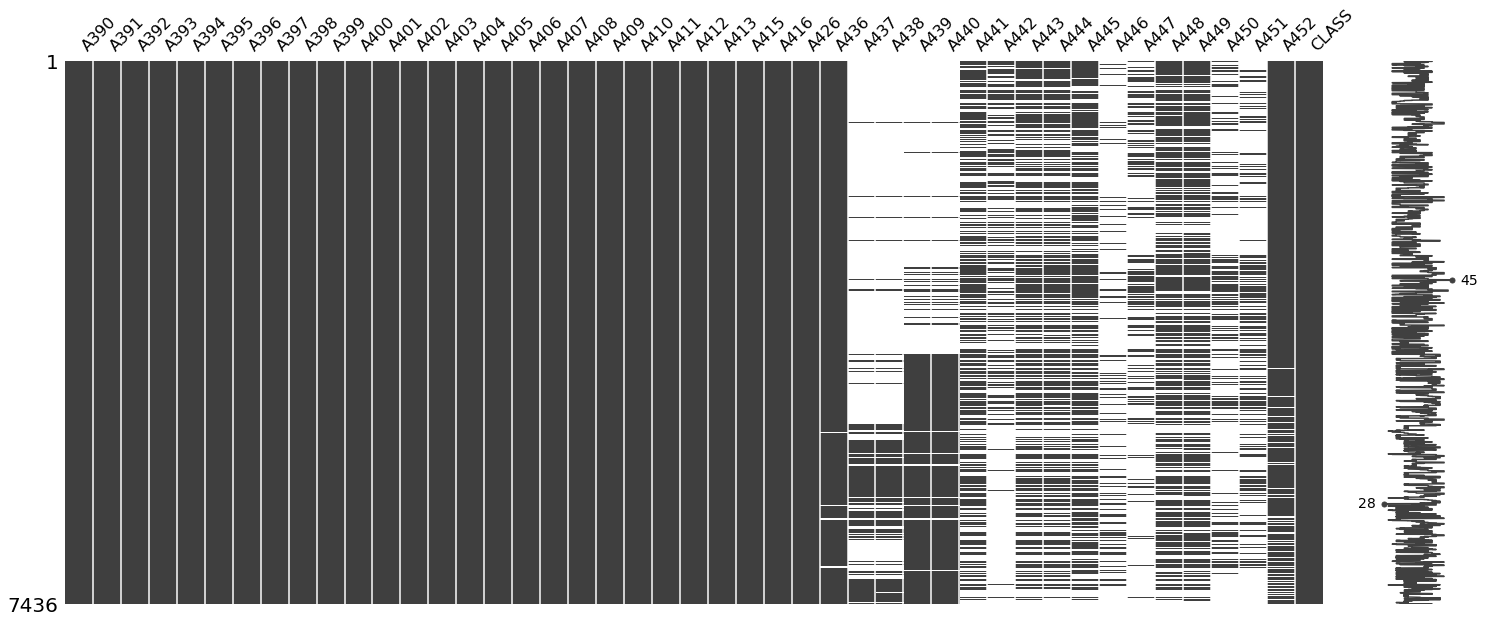

In [21]:
msno.matrix(bdp_train_valid_columns_pd.iloc[:, 200:len(valid_columns)])

In [22]:
bdp_train_valid_columns_pd.describe()

23/01/24 07:34:44 WARN DAGScheduler: Broadcasting large task binary with size 1646.6 KiB


,Index,A84,A85,A86,A87,A88,A89,A90,A91,A92,A93,A94,A95,A96,A97,A98,A99,A100,A101,A102,A103,A104,A105,A106,A107,A108,A109,A110,A111,A112,A113,A114,A115,A116,A117,A118,A119,A120,A121,A122,A123,A124,A125,A126,A127,A128,A129,A130,A131,A132,A133,A134,A135,A136,A137,A138,A139,A140,A141,A142,A143,A144,A145,A146,A147,A148,A149,A150,A151,A152,A153,A154,A155,A156,A157,A158,A159,A160,A161,A162,A163,A164,A165,A166,A168,A169,A170,A171,A172,A173,A174,A175,A176,A207,A271,A295,A358,A359,A360,A361,A362,A363,A364,A366,A367,A368,A369,A370,A371,A372,A373,A374,A375,A376,A377,A378,A379,A381,A382,A383,A384,A385,A386,A387,A388,A389,A390,A391,A392,A393,A394,A395,A396,A397,A398,A399,A400,A401,A402,A403,A404,A405,A406,A407,A408,A409,A410,A411,A412,A413,A415,A416,A426,A436,A437,A438,A439,A440,A441,A442,A443,A444,A445,A446,A447,A448,A449,A450,A451,A452
count,7436.000000,6101.000000,3011.000000,50.000000,7065.000000,4983.000000,3939.000000,6482.000000,3439.000000,4016.000000,1107.000000,863.000000,1225.000000,7393.000000,4010.000000,127.000000,265.000000,7436.000000,7436.000000,2859.000000,3669.000000,897.000000,664.000000,214.000000,56.000000,751.000000,308.000000,828.000000,1075.000000,6996.000000,7352.000000,10.000000,3556.000000,10.000000,3860.000000,3631.000000,1091.000000,3659.000000,3646.000000,1066.000000,1451.000000,1882.000000,694.000000,191.000000,2.538000e+03,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.00000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,36.000000,1947.000000,253.000000,56.000000,66.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7357.000000,1801.000000,1790.000000,3626.000000,3626.000000,4077.000000,2039.000000,3901.000000,3864.000000,4394.000000,1104.000000,1828.000000,4595.000000,4686.000000,1816.000000,2115.000000,6981.000000
mean,3718.500000,12.613998,14.471936,29.260000,7.889738,28.068834,8.405687,27.125270,19.974654,14.733815,17.180668,22.979143,28.982857,15.685378,18.571820,41.173228,48.656604,21.577999,37.218800,71.476390,72.020442,32.555072,75.323795,61.691589,197.000000,78.323569,219.022727,28.867391,59.034158,8.903087,197.896255,482.300000,73.450787,1138.900000,598.316114,589.678284,729.900458,730.234031,713.367869,710.957692,643.150930,284.079081,23874.165706,13937.256545,3.286432e+05,0.364847,0.026358,0.005514,0.014389,0.030393,0.006186,0.006321,0.006724,0.015196,0.058096,0.00901,0.002152,0.003093,0.011834,0.002421,0.003900,0.003765,0.000403,0.040344,0.007800,0.002959,0.000941,0.002152,0.011700,0.002824,0.009683,0.000538,0.006455,0.012103,0.001345,0.005379,0.011700,0.007800,0.002017,0.004976,0.000807,0.000134,0.004572,0.001076,0.008876,0.001076,0.002017,0.001210,0.001883,0.000269,0.001076,0.000269,0.005110,0.231442,0.427380,0.345078,0.636229,1.138889,1.918850,1.747036,3.142857,5.090909,0.111350,0.000403,0.003497,0.002824,0.006590,0.014524,0.054734,0.000807,0.000269,0.001210,0.006321,0.000134,0.000941,0.000941,0.000672,0.002555,0.001345,0.

In [23]:
expression = [count(when(col(c).contains('None') | \
                         col(c).contains('NULL') | \
                         (col(c) == '' ) | \
                         isnan(c) | \
                         col(c).isNull(), c)).alias(c) for c in bdp_train_valid_columns.columns]

num_null_values_df = bdp_train_valid_columns.select(*expression)


expression = [count(when(col(c).contains('None') | \
                         col(c).contains('NULL') | \
                         (col(c) == '' ) | \
                         isnan(c) | \
                         col(c).isNull(), c)).alias(c) for c in bdp_test_valid_columns.columns]

num_null_values_test_df = bdp_test_valid_columns.select(*expression)

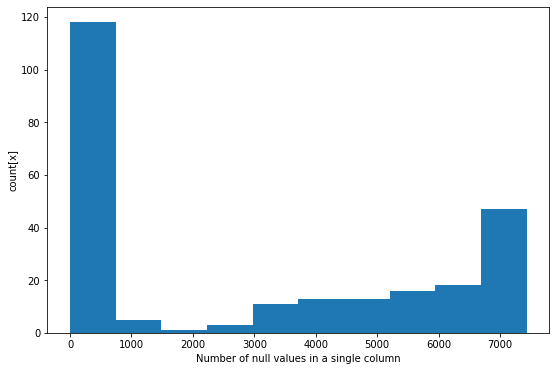

In [24]:
first_row_null_values = num_null_values_df.first()
num_null_values = np.array([first_row_null_values[c] for c in num_null_values_df.columns])

fig = plt.figure(figsize=(9, 6))
plt.hist(num_null_values)
plt.xlabel('Number of null values in a single column')
plt.ylabel('count[x]')
plt.show()

#### __filter columns with more than 3500 missing values (~47% of the samples):__
Note that columns A439 and A440 has more missing values than 3500, but have very big variation, so we will take them anyway

In [25]:
max_num_lacking_values = 3500
max_num_lacking_values_test = bdp_test.count() / 2

first_row_null_values_test = num_null_values_test_df.first()

valid_columns_train =  [c for c in num_null_values_df.columns if first_row_null_values[c] < max_num_lacking_values] + ['A439', 'A440']
valid_columns_test =  [c for c in num_null_values_test_df.columns if first_row_null_values_test[c] < max_num_lacking_values_test] + ['A439', 'A440']

valid_columns = []
for col in valid_columns_train:
    if col in valid_columns_test:
        valid_columns.append(col)

print(f'Number of valid columns (not including index, class): {len(valid_columns) - 1}')

Number of valid columns (not including index, class): 125


In [26]:
bdp_train_valid_columns = bdp_train_valid_columns.select(valid_columns + ['CLASS'])

### __Count binary and non binary columns__

In [27]:
binary_columns =  [c for c in bdp_train_valid_columns.columns if first_row_distinct_values[c] == 2]
non_binary_columns = [c for c in bdp_train_valid_columns.columns if not c in binary_columns]
print(f'Number of binary columns (not including class) is {len(binary_columns) - 1}')
print(f'Number of non binary columns (not including Index) is {len(non_binary_columns) - 1}')

Number of binary columns (not including class) is 98
Number of non binary columns (not including Index) is 27


### __Change string categorials to numeric categorials__

In [28]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep").fit(bdp_train_valid_columns) for column in valid_columns if pattern.match(column)]
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol = column+"_encoded") for column in bdp_train_valid_columns.columns if pattern.match(column)]

# Create new, indexes columns
pipeline = Pipeline(stages=indexers+encoders)
bdp_train_valid_columns = pipeline.fit(bdp_train_valid_columns).transform(bdp_train_valid_columns)

# Drop old columns
columns_to_drop = [column for column in bdp_train_valid_columns.columns if pattern.match(column)]
bdp_train_valid_columns = bdp_train_valid_columns.drop(*columns_to_drop)

# Rename new columns to the old name
to_rename = [column+"_index" for column in columns_to_drop]

bdp_train_valid_columns = reduce(lambda data, idx: data.withColumnRenamed(to_rename[idx], columns_to_drop[idx]), range(len(to_rename)), bdp_train_valid_columns)
bdp_train_valid_columns = bdp_train_valid_columns.select(valid_columns + ['CLASS'])

### __Check for similar columns (non binary - correlation, binary - Jaccard Distance)__

In [29]:
bdp_train_non_binary_columns_pd = bdp_train_valid_columns.select(non_binary_columns[1:]).toPandas()
bdp_train_binary_columns_pd = bdp_train_valid_columns.select(binary_columns[:-1]).toPandas()

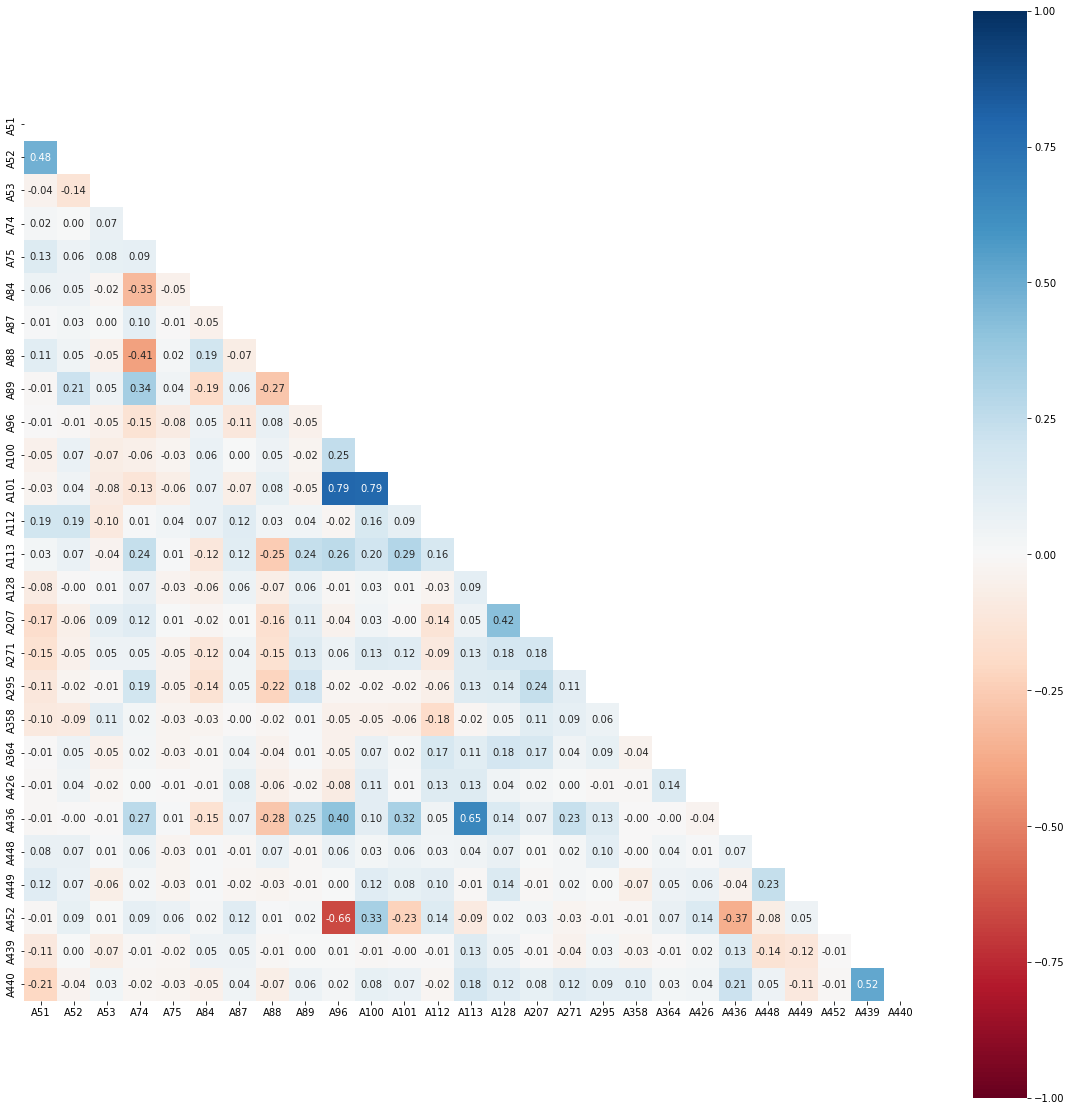

In [30]:
corr_matrix = bdp_train_non_binary_columns_pd.corr()

fig = plt.figure(figsize=(20, 20))
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, cmap='RdBu', mask = mask, vmin=-1, vmax=1, annot=True, fmt=".2f", square=True)
plt.show()

In [31]:
non_binary_columns_sdt = bdp_train_non_binary_columns_pd.std()
non_binary_columns_high_sdt = non_binary_columns_sdt.loc[non_binary_columns_sdt.values > 1]

In [32]:
non_binary_columns_high_sdt.index

Index(['A51', 'A52', 'A84', 'A87', 'A88', 'A89', 'A96', 'A100', 'A101', 'A112',
       'A113', 'A358', 'A436', 'A448', 'A449', 'A452', 'A439', 'A440'],
      dtype='object')

In [33]:
jacacrd_similarity_matrix = pd.DataFrame(np.zeros([len(bdp_train_binary_columns_pd.columns), len(bdp_train_binary_columns_pd.columns)]), columns = bdp_train_binary_columns_pd.columns, index = bdp_train_binary_columns_pd.columns)

for col_pair in itertools.combinations(bdp_train_binary_columns_pd.columns, 2):
#     print(col_pair)
#     print(jaccard_score(bdp_train_binary_columns_pd[col_pair[0]], bdp_train_binary_columns_pd[col_pair[1]], average='micro'))
    m11 = bdp_train_binary_columns_pd.loc[(bdp_train_binary_columns_pd[col_pair[0]] == 1) & (bdp_train_binary_columns_pd[col_pair[1]] == 1), :].shape[0]
    m01 = bdp_train_binary_columns_pd.loc[(bdp_train_binary_columns_pd[col_pair[0]] == 0) & (bdp_train_binary_columns_pd[col_pair[1]] == 1), :].shape[0]
    m10 = bdp_train_binary_columns_pd.loc[(bdp_train_binary_columns_pd[col_pair[0]] == 1) & (bdp_train_binary_columns_pd[col_pair[1]] == 0), :].shape[0]
    m00 = bdp_train_binary_columns_pd.loc[(bdp_train_binary_columns_pd[col_pair[0]] == 0) & (bdp_train_binary_columns_pd[col_pair[1]] == 0), :].shape[0]
    
    jacacrd_similarity_matrix[col_pair[0]][col_pair[1]] =  jaccard_score(bdp_train_binary_columns_pd[col_pair[0]], bdp_train_binary_columns_pd[col_pair[1]], average='micro')
    
#     interesting_as = ['A25', 'A137', 'A146', 'A371', 'A129', 'A132', 'A406']

#     if col_pair[0] in interesting_as:
#         print(m11, m01, m10, m00)

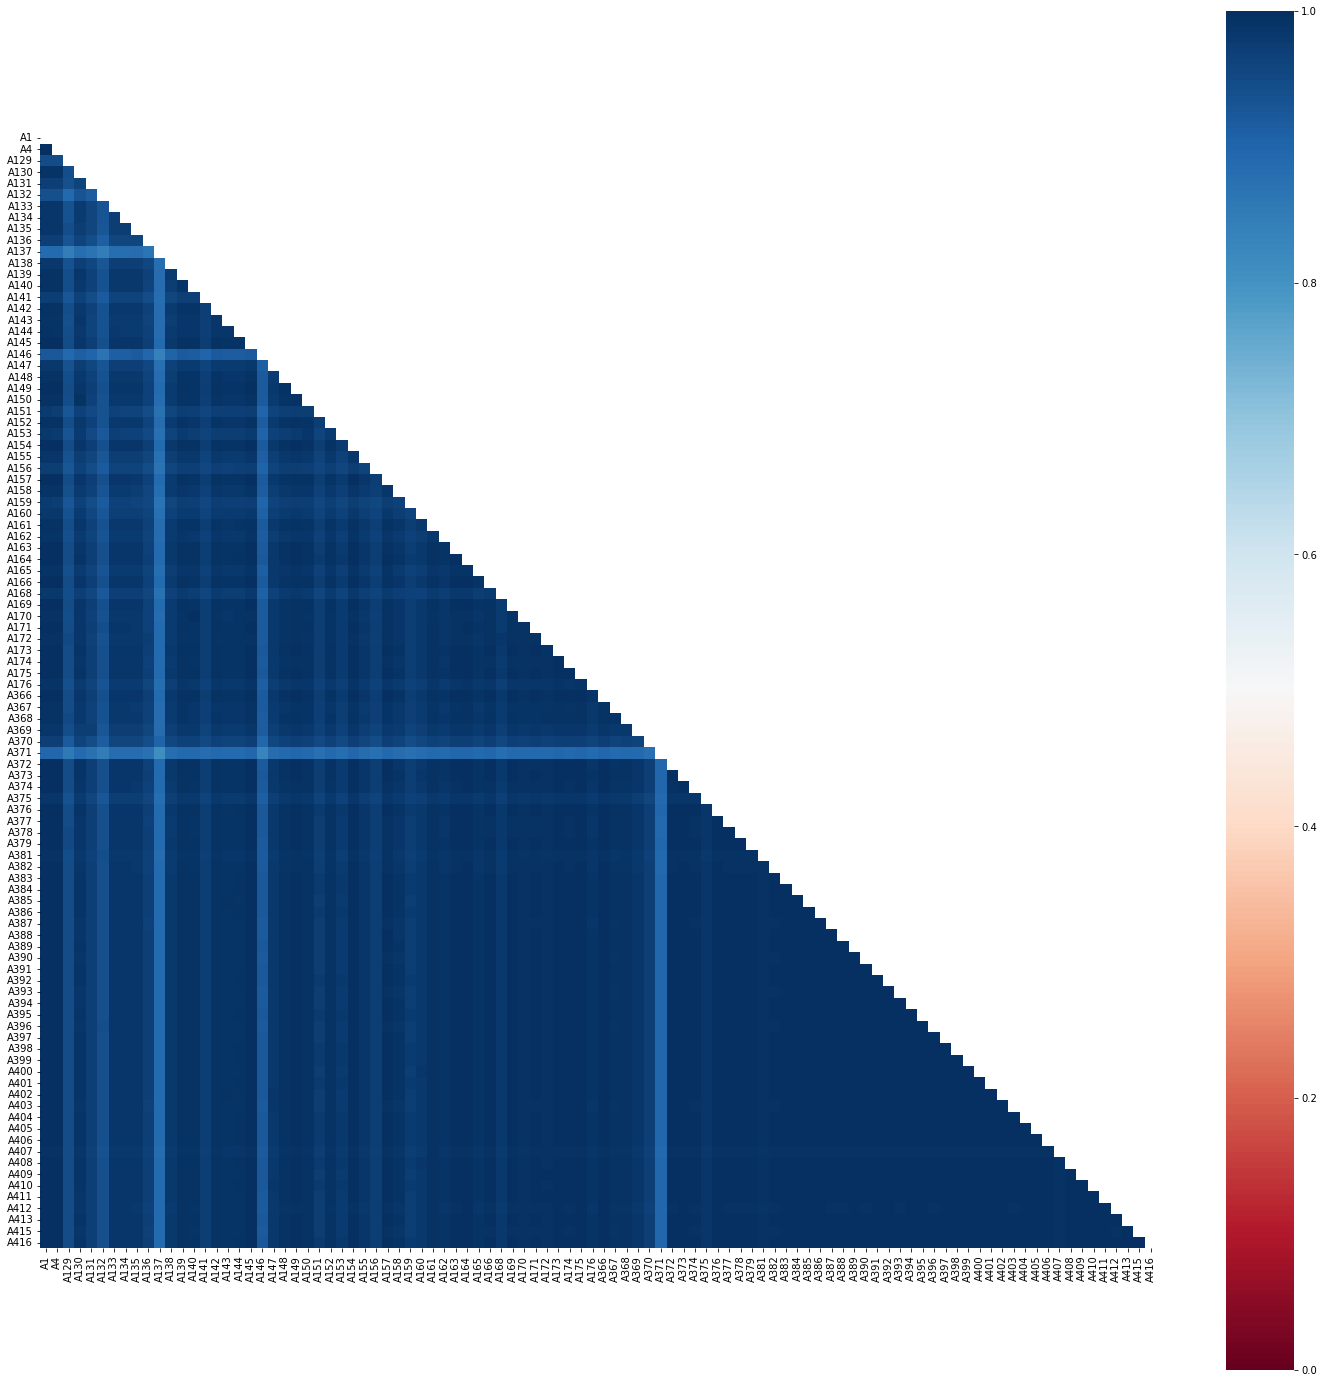

In [34]:
fig = plt.figure(figsize=(25, 25))
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(jacacrd_similarity_matrix, dtype=bool))
sns.heatmap(jacacrd_similarity_matrix, cmap='RdBu', mask = mask, vmin=0, vmax=1, square=True)
plt.show()

### __Prepare data for training and evaluation__

In [35]:
training_columns = non_binary_columns[1:] #+ ['A25', 'A1']
# training_columns = non_binary_columns_high_sdt.index.to_list() #+ ['A25', 'A137', 'A146', 'A371', 'A129', 'A132', 'A406']
    
bdp_train_valid_columns = bdp_train_valid_columns.fillna(-1, subset=training_columns)

In [36]:
assembler = VectorAssembler(inputCols=training_columns, outputCol='features', handleInvalid="keep")
bdp_train_assembler = assembler.transform(bdp_train_valid_columns).select('index', 'features', 'CLASS')

In [37]:
bdp_train_assembler.show()

+-----+--------------------+-----+
|index|            features|CLASS|
+-----+--------------------+-----+
|    1|[3.0,1.0,0.0,2.0,...|   No|
|    2|[3.0,1.0,0.0,2.0,...|  Yes|
|    3|[3.0,1.0,2.0,1.0,...|  Yes|
|    4|[3.0,1.0,2.0,1.0,...|  Yes|
|    5|[3.0,1.0,2.0,1.0,...|  Yes|
|    6|[3.0,1.0,0.0,1.0,...|  Yes|
|    7|[3.0,1.0,0.0,1.0,...|  Yes|
|    8|[3.0,1.0,0.0,1.0,...|   No|
|    9|[3.0,1.0,0.0,1.0,...|   No|
|   10|[3.0,1.0,0.0,1.0,...|   No|
|   11|[3.0,1.0,0.0,1.0,...|   No|
|   12|[3.0,3.0,0.0,1.0,...|   No|
|   13|[3.0,3.0,0.0,1.0,...|   No|
|   14|[3.0,3.0,0.0,1.0,...|   No|
|   15|[3.0,3.0,0.0,1.0,...|   No|
|   16|[3.0,3.0,0.0,1.0,...|   No|
|   17|[3.0,0.0,0.0,1.0,...|  Yes|
|   18|[3.0,0.0,0.0,1.0,...|   No|
|   19|[3.0,0.0,0.0,1.0,...|   No|
|   20|[3.0,0.0,0.0,1.0,...|   No|
+-----+--------------------+-----+
only showing top 20 rows



In [38]:
indexer = StringIndexer(inputCol='CLASS', outputCol='label')

In [39]:
bdp_train_assembler = indexer.fit(bdp_train_assembler).transform(bdp_train_assembler)

In [40]:
# build a dataframe that will be fed to the model
train_data_feed = bdp_train_assembler.select('index', 'features','label')
train_data_feed.show()

+-----+--------------------+-----+
|index|            features|label|
+-----+--------------------+-----+
|    1|[3.0,1.0,0.0,2.0,...|  0.0|
|    2|[3.0,1.0,0.0,2.0,...|  1.0|
|    3|[3.0,1.0,2.0,1.0,...|  1.0|
|    4|[3.0,1.0,2.0,1.0,...|  1.0|
|    5|[3.0,1.0,2.0,1.0,...|  1.0|
|    6|[3.0,1.0,0.0,1.0,...|  1.0|
|    7|[3.0,1.0,0.0,1.0,...|  1.0|
|    8|[3.0,1.0,0.0,1.0,...|  0.0|
|    9|[3.0,1.0,0.0,1.0,...|  0.0|
|   10|[3.0,1.0,0.0,1.0,...|  0.0|
|   11|[3.0,1.0,0.0,1.0,...|  0.0|
|   12|[3.0,3.0,0.0,1.0,...|  0.0|
|   13|[3.0,3.0,0.0,1.0,...|  0.0|
|   14|[3.0,3.0,0.0,1.0,...|  0.0|
|   15|[3.0,3.0,0.0,1.0,...|  0.0|
|   16|[3.0,3.0,0.0,1.0,...|  0.0|
|   17|[3.0,0.0,0.0,1.0,...|  1.0|
|   18|[3.0,0.0,0.0,1.0,...|  0.0|
|   19|[3.0,0.0,0.0,1.0,...|  0.0|
|   20|[3.0,0.0,0.0,1.0,...|  0.0|
+-----+--------------------+-----+
only showing top 20 rows



In [41]:
scaler = MinMaxScaler(min=0., max=1., inputCol="features", outputCol="scaledFeatures")

# Normalize the data
scaledData = scaler.fit(train_data_feed).transform(train_data_feed)

scaledData.show(5)

+-----+--------------------+-----+--------------------+
|index|            features|label|      scaledFeatures|
+-----+--------------------+-----+--------------------+
|    1|[3.0,1.0,0.0,2.0,...|  0.0|(27,[0,1,3,5,6,7,...|
|    2|[3.0,1.0,0.0,2.0,...|  1.0|(27,[0,1,3,5,6,7,...|
|    3|[3.0,1.0,2.0,1.0,...|  1.0|(27,[0,1,2,3,5,6,...|
|    4|[3.0,1.0,2.0,1.0,...|  1.0|[1.0,0.3333333333...|
|    5|[3.0,1.0,2.0,1.0,...|  1.0|(27,[0,1,2,3,5,6,...|
+-----+--------------------+-----+--------------------+
only showing top 5 rows



In [42]:
train_data, val_data = scaledData.randomSplit([0.8, 0.2])

In [43]:
train_data.distinct().show(5)

+-----+--------------------+-----+--------------------+
|index|            features|label|      scaledFeatures|
+-----+--------------------+-----+--------------------+
|  144|(27,[3,5,6,7,8,10...|  0.0|(27,[3,5,6,7,9,10...|
|  155|[3.0,0.0,0.0,1.0,...|  1.0|(27,[0,3,5,6,7,9,...|
|  218|[0.0,0.0,2.0,0.0,...|  1.0|(27,[2,5,6,7,9,10...|
|  336|(27,[0,5,6,7,8,10...|  1.0|(27,[0,5,6,7,9,10...|
|  713|[0.0,3.0,0.0,1.0,...|  0.0|(27,[1,3,5,6,7,9,...|
+-----+--------------------+-----+--------------------+
only showing top 5 rows



### __Test different classifiers with cross-validation__

In [44]:
def print_result(classifier,scores,results_df):
    # extract params and use it as the base for ditionary rsults
    dict_res = {'Classifier' : classifier}

    # recall
    dict_res['Train score'] = np.mean(scores[0]) * 100
    dict_res['Val score'] = np.mean(scores[1]) * 100
    
    # print results
    print(f"Classifier: {dict_res['Classifier']}")
    print(f"Train score: {np.round(dict_res['Train score'],2)}, Validation score {np.round(dict_res['Val score'],2)}")
    
    results_df = results_df.append(dict_res, ignore_index=True)

    return results_df

In [45]:
results_df = pd.DataFrame()

In [46]:
# In use for all models
binary_eval = BinaryClassificationEvaluator(labelCol='label')
evaluator = BinaryClassificationEvaluator()

In [47]:
from pyspark.ml.classification import LogisticRegression

estimator = LogisticRegression(featuresCol = 'scaledFeatures')
grid = ParamGridBuilder().addGrid(estimator.regParam, [0, 0.1, 0.01, 0.001]).build()
cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator)
LR_model = cv.fit(train_data)

cv_preds = LR_model.transform(val_data)

val_score = binary_eval.evaluate(cv_preds)

results_df = print_result('Logistic Regression',[max(LR_model.avgMetrics), val_score],results_df)

Classifier: Logistic Regression
Train score: 71.27, Validation score 70.59


In [48]:
from pyspark.ml.classification import DecisionTreeClassifier

estimator = DecisionTreeClassifier(featuresCol = 'scaledFeatures')
grid = ParamGridBuilder().addGrid(estimator.maxDepth, [2, 3, 5, 7, 10]).addGrid(estimator.impurity, ['entropy', 'gini']).build()
cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator)
DT_model = cv.fit(train_data)

cv_preds = DT_model.transform(val_data)

val_score = binary_eval.evaluate(cv_preds)

results_df = print_result('Decision Tree',[max(DT_model.avgMetrics), val_score],results_df)

Classifier: Decision Tree
Train score: 59.35, Validation score 64.3


In [49]:
from pyspark.ml.classification import GBTClassifier

estimator = GBTClassifier(featuresCol = 'scaledFeatures')
grid = ParamGridBuilder().addGrid(estimator.maxDepth, np.arange(2, 11, 1)).build()
cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator)
GBT_model = cv.fit(train_data)

cv_preds = GBT_model.transform(val_data)

val_score = binary_eval.evaluate(cv_preds)

results_df = print_result('Gradient-Boosted Trees',[max(GBT_model.avgMetrics), val_score],results_df)

23/01/24 07:37:36 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB
23/01/24 07:37:36 WARN DAGScheduler: Broadcasting large task binary with size 1014.8 KiB
23/01/24 07:37:36 WARN DAGScheduler: Broadcasting large task binary with size 1030.4 KiB
23/01/24 07:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1024.5 KiB
23/01/24 07:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1015.5 KiB
23/01/24 07:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1048.3 KiB
23/01/24 07:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1040.8 KiB
23/01/24 07:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1041.3 KiB
23/01/24 07:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1041.8 KiB
23/01/24 07:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1043.0 KiB
23/01/24 07:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1045.2 KiB
23/01/24 07:37:45 WAR

In [50]:
from pyspark.ml.classification import RandomForestClassifier

estimator = RandomForestClassifier(featuresCol = 'scaledFeatures')
grid = ParamGridBuilder().addGrid(estimator.maxDepth, np.arange(2, 11, 1)).addGrid(estimator.numTrees, [10, 20, 30]).build()
cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator)
RF_model = cv.fit(train_data)

cv_preds = RF_model.transform(val_data)

val_score = binary_eval.evaluate(cv_preds)

results_df = print_result('Random Forest',[max(RF_model.avgMetrics), val_score],results_df)

23/01/24 07:40:44 WARN DAGScheduler: Broadcasting large task binary with size 1136.8 KiB
23/01/24 07:40:48 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
23/01/24 07:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1136.8 KiB
23/01/24 07:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1542.1 KiB
23/01/24 07:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1114.7 KiB
23/01/24 07:41:18 WARN DAGScheduler: Broadcasting large task binary with size 1115.3 KiB
23/01/24 07:41:22 WARN DAGScheduler: Broadcasting large task binary with size 1053.2 KiB
23/01/24 07:41:24 WARN DAGScheduler: Broadcasting large task binary with size 1115.3 KiB
23/01/24 07:41:25 WARN DAGScheduler: Broadcasting large task binary with size 1521.6 KiB
23/01/24 07:41:25 WARN DAGScheduler: Broadcasting large task binary with size 1099.2 KiB
23/01/24 07:41:53 WARN DAGScheduler: Broadcasting large task binary with size 1122.4 KiB
23/01/24 07:41:57 WAR

In [51]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

estimator = MultilayerPerceptronClassifier(layers=[len(training_columns), 16, 8, 4, 2], maxIter = 300, featuresCol = 'scaledFeatures')
grid = ParamGridBuilder().addGrid(estimator.stepSize, np.arange(0.001, 0.011, 0.001)).addGrid(estimator.solver, ['gd', 'l-bfgs']).build()
cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator)
MLP_model = cv.fit(train_data)

cv_preds = MLP_model.transform(val_data)

val_score = binary_eval.evaluate(cv_preds)

results_df = print_result('Multi layer perceptron',[max(MLP_model.avgMetrics), val_score],results_df)

23/01/24 07:42:13 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/01/24 07:42:13 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
Classifier: Multi layer perceptron
Train score: 75.83, Validation score 80.56


In [52]:
from pyspark.ml.classification import FMClassifier

estimator = FMClassifier(featuresCol = 'scaledFeatures')
grid = ParamGridBuilder().addGrid(estimator.factorSize, np.arange(1, 10, 1)).addGrid(estimator.solver, ['gd', 'adamW']).build()
cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator)
FM_model = cv.fit(train_data)

cv_preds = FM_model.transform(val_data)

val_score = binary_eval.evaluate(cv_preds)

results_df = print_result('FM classifier',[max(FM_model.avgMetrics), val_score],results_df)

23/01/24 07:51:32 WARN BlockManager: Asked to remove block broadcast_55737, which does not exist
23/01/24 07:53:39 WARN BlockManager: Block broadcast_61320 could not be removed as it was not found on disk or in memory
23/01/24 07:53:39 ERROR BlockManagerStorageEndpoint: Error in removing broadcast 61320
org.apache.spark.SparkException: Block broadcast_61320 does not exist
	at org.apache.spark.errors.SparkCoreErrors$.blockDoesNotExistError(SparkCoreErrors.scala:234)
	at org.apache.spark.storage.BlockInfoManager.blockInfo(BlockInfoManager.scala:237)
	at org.apache.spark.storage.BlockInfoManager.removeBlock(BlockInfoManager.scala:500)
	at org.apache.spark.storage.BlockManager.removeBlockInternal(BlockManager.scala:1994)
	at org.apache.spark.storage.BlockManager.removeBlock(BlockManager.scala:1972)
	at org.apache.spark.storage.BlockManager.$anonfun$removeBroadcast$3(BlockManager.scala:1958)
	at org.apache.spark.storage.BlockManager.$anonfun$removeBroadcast$3$adapted(BlockManager.scala:1958

In [53]:
# from pyspark.ml.classification import NaiveBayes

# estimator = NaiveBayes(featuresCol = 'scaledFeatures')
# grid = ParamGridBuilder().addGrid(estimator.modelType, ['multinomial', 'bernoulli', 'gaussian']).build()
# cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator)
# NB_model = cv.fit(train_data)

# cv_preds = NB_model.transform(val_data)

# val_score = binary_eval.evaluate(cv_preds)

# results_df = print_result('Naive Bayes',[max(NB_model.avgMetrics), val_score],results_df)

In [54]:
results_df

,Classifier,Train score,Val score
0,Logistic Regression,71.271357,70.591831
1,Decision Tree,59.354943,64.297509
2,Gradient-Boosted Trees,77.597619,77.242661
3,Random Forest,77.796919,78.124759
4,Multi layer perceptron,75.827479,80.557068
5,FM classifier,72.256827,72.296543


### __select best classifier and predict test data with it__

In [55]:
selected_model = MLP_model

In [56]:
# # Use Spark to read the training csv file.
# bdp_test = spark.read.csv("/kaggle/input/big-data-platforms-competition-2023/bdp_test.csv", inferSchema=True, header=True)\
#                  .fillna(0, subset=training_columns)\
#                  .withColumn("A103", f.col("A103").cast('int'))\
#                  .withColumn("A102", f.col("A102").cast('int'))\
#                  .withColumn("A97", f.col("A97").cast('int'))\
#                  .withColumn("A92", f.col("A92").cast('int'))\
#                  .withColumn("A115", f.col("A115").cast('int'))

# Use Spark to read the test csv file.
bdp_test = spark.read.csv("/kaggle/input/big-data-platforms-competition-2023/bdp_test.csv", inferSchema=True, header=True)

In [57]:
bdp_test = bdp_test.select(training_columns + ['Index']).fillna(-1, subset=training_columns)

In [58]:
print(f'Dataset shape: ({bdp_test.count()}, {len(bdp_test.columns)})')

Dataset shape: (3186, 28)


In [59]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep").fit(bdp_test) for column in training_columns if pattern.match(column)]
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol = column+"_encoded") for column in training_columns if pattern.match(column)]

# Create new, indexes columns
pipeline = Pipeline(stages=indexers+encoders)
bdp_test = pipeline.fit(bdp_test).transform(bdp_test)

# Drop old columns
columns_to_drop = [column for column in bdp_test.columns if pattern.match(column)]
bdp_test = bdp_test.drop(*columns_to_drop)

# Rename new columns to the old name
to_rename = [column+"_index" for column in columns_to_drop]

bdp_test = reduce(lambda data, idx: data.withColumnRenamed(to_rename[idx], columns_to_drop[idx]), range(len(to_rename)), bdp_test)
bdp_test = bdp_test.select(training_columns + ['Index'])

In [60]:
test_data = assembler.transform(bdp_test).select('index', 'features')
test_scaled_data = scaler.fit(train_data_feed).transform(test_data)

In [61]:
test_scaled_data.show()

+-----+--------------------+--------------------+
|index|            features|      scaledFeatures|
+-----+--------------------+--------------------+
|    1|(27,[0,2,5,6,7,8,...|(27,[0,2,5,6,7,8,...|
|    2|(27,[3,5,6,7,8,12...|(27,[3,5,6,7,8,9,...|
|    3|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|
|    4|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|
|    5|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|
|    6|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|
|    7|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|
|    8|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|
|    9|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|
|   10|(27,[1,2,3,5,6,7,...|(27,[1,2,3,5,6,7,...|
|   11|[0.0,1.0,2.0,1.0,...|(27,[1,2,3,5,7,8,...|
|   12|[0.0,1.0,2.0,1.0,...|[0.0,0.3333333333...|
|   13|[0.0,1.0,2.0,1.0,...|[0.0,0.3333333333...|
|   14|(27,[1,3,5,6,7,8,...|(27,[1,3,5,6,7,8,...|
|   15|[0.0,1.0,0.0,1.0,...|[0.0,0.3333333333...|
|   16|[0.0,1.0,0.0,1.0,...|[0.0,0.3333333333...|
|   17|[0.0,1.0,0.0,1.0,...|[0.0,0.3333333333...|


In [62]:
test_preds = selected_model.transform(test_scaled_data)

In [63]:
test_preds.show()

+-----+--------------------+--------------------+--------------------+--------------------+----------+
|index|            features|      scaledFeatures|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+----------+
|    1|(27,[0,2,5,6,7,8,...|(27,[0,2,5,6,7,8,...|[1.39761739215001...|[0.97849413686441...|       0.0|
|    2|(27,[3,5,6,7,8,12...|(27,[3,5,6,7,8,9,...|[-1.1016713454128...|[0.26321102685617...|       1.0|
|    3|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|[-1.2025904435190...|[0.23299903843023...|       1.0|
|    4|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|[-1.3504676794533...|[0.19234372777973...|       1.0|
|    5|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|[-0.9594685368718...|[0.33326450623601...|       1.0|
|    6|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|[0.84201811586426...|[0.93805831864712...|       0.0|
|    7|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|[0.98231422684618...|[0.

In [64]:
test_preds.distinct().show(5)

+-----+--------------------+--------------------+--------------------+--------------------+----------+
|index|            features|      scaledFeatures|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+----------+
|   67|(27,[2,5,6,7,8,9,...|(27,[2,5,6,7,8,9,...|[-0.0993391895411...|[0.70826180006721...|       0.0|
|  102|(27,[2,5,6,7,8,12...|(27,[2,5,6,7,8,9,...|[0.70800584112615...|[0.91558219638309...|       0.0|
|  138|[1.0,0.0,0.0,0.0,...|(27,[0,5,6,7,8,9,...|[1.18605504429783...|[0.96421559591294...|       0.0|
|  650|[0.0,0.0,3.0,1.0,...|[0.0,0.0,1.0,0.25...|[-1.2358239282563...|[0.23230489392552...|       1.0|
| 1125|(27,[3,5,6,7,8,10...|[0.0,0.0,0.0,0.25...|[0.11506836159721...|[0.79520528593291...|       0.0|
+-----+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [65]:
test_preds.head()

Row(index=1, features=SparseVector(27, {0: 1.0, 2: 2.0, 5: 7.0, 6: 7.0, 7: 35.0, 8: 70.0, 10: 14.0, 11: 14.0, 12: 147.0, 13: 147.0, 21: 133.0, 22: -1.0, 23: -1.0, 24: 7.0, 25: 812.0, 26: 546.0}), scaledFeatures=SparseVector(27, {0: 0.3333, 2: 0.6667, 5: 0.2222, 6: 0.186, 7: 0.72, 8: 1.0, 9: 0.0109, 10: 0.1111, 11: 0.087, 12: 0.8, 13: 0.4134, 21: 0.4241, 24: 1.0, 25: 0.7298, 26: 0.7095}), rawPrediction=DenseVector([1.3976, -2.4201]), probability=DenseVector([0.9785, 0.0215]), prediction=0.0)

In [66]:
from pyspark.ml.functions import vector_to_array
test_preds.withColumn('ProbToYes', vector_to_array(f.col('probability')).getItem(1)).show()

+-----+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|index|            features|      scaledFeatures|       rawPrediction|         probability|prediction|           ProbToYes|
+-----+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|    1|(27,[0,2,5,6,7,8,...|(27,[0,2,5,6,7,8,...|[1.39761739215001...|[0.97849413686441...|       0.0| 0.02150586313558491|
|    2|(27,[3,5,6,7,8,12...|(27,[3,5,6,7,8,9,...|[-1.1016713454128...|[0.26321102685617...|       1.0|  0.7367889731438286|
|    3|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|[-1.2025904435190...|[0.23299903843023...|       1.0|  0.7670009615697684|
|    4|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|[-1.3504676794533...|[0.19234372777973...|       1.0|  0.8076562722202635|
|    5|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.75...|[-0.9594685368718...|[0.33326450623601...|       1.0|  0.6667354937639894|
|    6|[

In [67]:
test_preds = selected_model.transform(test_scaled_data)\
                          .withColumn('ProbToYes', vector_to_array(f.col('probability')).getItem(1))\
                          .select('index', 'ProbToYes')

In [68]:
test_preds.printSchema()

root
 |-- index: integer (nullable = true)
 |-- ProbToYes: double (nullable = true)



In [69]:
test_preds.show(5)

+-----+-------------------+
|index|          ProbToYes|
+-----+-------------------+
|    1|0.02150586313558491|
|    2| 0.7367889731438286|
|    3| 0.7670009615697684|
|    4| 0.8076562722202635|
|    5| 0.6667354937639894|
+-----+-------------------+
only showing top 5 rows



In [70]:
test_preds.coalesce(1).write.mode('overwrite').csv('/kaggle/working/Best_predictions_(MLP).csv', header = 'true')

In [71]:
os.chdir(r'/kaggle/working')

In [72]:
from IPython.display import FileLinks
FileLinks(r'./predictions_MLP_scaled_data.csv')

Path ( ./predictions_MLP_scaled_data.csv ) doesn't exist. It may still be in the process of being generated, or you may have the incorrect path.

In [73]:
selected_model.save(r'./Best_MPL_model/')